In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model_2flares2ars, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares2ars

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
tstamp = '13_01_2020_11_28'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
R_jup,R_sun

(<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal Jupiter equatorial radius' value=71492000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>,
 <<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>)

In [5]:
lcs = pd.Series({"rad":pd.Series([(2.1*R_jup/R_sun).decompose().value]),
                "Prot_d":pd.Series([2.84/24]),
                "vsini_kms":pd.Series([49.2]),
                "e_vsini_kms":pd.Series([4.9]),})
get_incl(lcs), lcs.rad.values

(rad            0    0.215802
 dtype: float64
 Prot_d         0    0.118333
 dtype: float64
 vsini_kms          0    49.2
 dtype: float64
 e_vsini_kms         0    4.9
 dtype: float64
 incl               [0.5624355126392725 rad]
 incl_err              [0.06277851710766706]
 dtype: object, array([0.21580164]))

In [6]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
guesses

,prefix,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot,theta_a_init
0,TIC,237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43,60.0
1,KIC,100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88,70.0
2,TIC,44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71,NaN
3,TIC,277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56,NaN
4,EPIC,212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,29.07702,2.06769,4.63,NaN


In [7]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [8]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126


In [9]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[2]
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [10]:
# from altaipony.altai import find_iterative_median
# from altaipony.flarelc import FlareLightCurve
# from funcs.custom_detrending import refine_detrended_flux_err
# from funcs.multiperiod import remove_sinusoidal
# from funcs.helper import fetch_lightcurve

# flck = fetch_lightcurve(target)

# t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
# print(t)
# F = FlareLightCurve(time=t, detrended_flux=sflux, 
#                     detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
# print(F.detrended_flux_err)
# flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
#                                      std_rolling_window_length=15, pad=25)

# choice = (t > target.view_start) & (t < target.view_stop) 
# # only one flare in TIC 237 : + 1.56 - 1.
# t = t[choice]
# flux = sflux[choice]
# flux_err = np.nanmean(flcd.detrended_flux_err)
# median = np.nanmean(find_iterative_median(F).it_med)
# phi = (t - t[0])/target.Prot_d * 2 * np.pi

# pd.DataFrame({"phi":phi,"flux":flux, "t":t,
#               "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
#                                                              index=False)
# median

(10, 25)

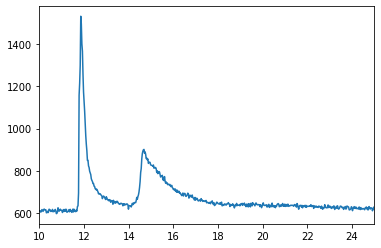

In [11]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(phi,flux)
plt.xlim(10,25)

In [12]:

phi_a = (11.8,(target.t0 - t[0])/target.Prot_d * 2 * np.pi)
theta_a = (49*np.pi/180, 59*np.pi/180)
a = (1.5, target.ampl)
fwhm = (0.5, target.dur /target.Prot_d * 2 * np.pi/5)
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = (phi[-1], phi[-1])
for _a in a:
    radius = calculate_angular_radius(Fth, _a, qlum, R)
    print(radius)
theta_a, i_mu, phi_a


20.9253963026697
11.485683712824796


((0.8552113334772214, 1.0297442586766543),
 0.3718561470554695,
 (11.8, 14.724101266474062))

(600, 1000)

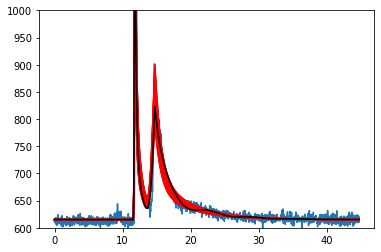

In [13]:
plt.plot(phi,flux)
for i in range(0,360,20):
    plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, full_model_2flares2ars(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1000)

### Save inits

In [14]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
    f.write(firstout)
    f.write(out)

## Run MCMC

In [15]:

inits = np.array([*phi_a, *theta_a, *a, *fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 10))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [16]:

sampler.run_mcmc(pos, 50, progress=True, store=True);

100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


In [29]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

Initial size: 11635


In [30]:
tstamp, target.ID

('13_01_2020_11_28', 237880881)

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares2ars, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

  0%|          | 20/50000 [03:22<141:56:08, 10.22s/it]

INF PRIOR


  0%|          | 26/50000 [04:22<140:22:14, 10.11s/it]

INF PRIOR


  0%|          | 28/50000 [04:42<140:37:01, 10.13s/it]

INF PRIOR


  0%|          | 30/50000 [05:02<139:02:57, 10.02s/it]

INF PRIOR


  0%|          | 38/50000 [06:22<138:46:13, 10.00s/it]

INF PRIOR


  0%|          | 47/50000 [07:54<140:10:18, 10.10s/it]

INF PRIOR


  0%|          | 49/50000 [08:13<136:52:30,  9.86s/it]

INF PRIOR


  0%|          | 53/50000 [08:53<140:36:45, 10.13s/it]

INF PRIOR


  0%|          | 64/50000 [10:46<145:39:51, 10.50s/it]

INF PRIOR


  0%|          | 73/50000 [12:18<142:29:12, 10.27s/it]

INF PRIOR


  0%|          | 80/50000 [13:28<142:06:08, 10.25s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  0%|          | 119/50000 [20:12<139:58:27, 10.10s/it]

INF PRIOR


  0%|          | 123/50000 [20:55<143:39:50, 10.37s/it]

INF PRIOR


  0%|          | 124/50000 [21:04<138:22:50,  9.99s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  0%|          | 132/50000 [22:23<136:35:43,  9.86s/it]

INF PRIOR


  0%|          | 142/50000 [24:03<138:05:39,  9.97s/it]

INF PRIOR
INF PRIOR


  0%|          | 144/50000 [24:22<133:23:18,  9.63s/it]

INF PRIOR


  0%|          | 153/50000 [25:51<139:58:36, 10.11s/it]

INF PRIOR


  0%|          | 164/50000 [27:41<138:25:06, 10.00s/it]

INF PRIOR


  0%|          | 171/50000 [28:51<138:43:40, 10.02s/it]

INF PRIOR


  0%|          | 179/50000 [30:13<138:52:38, 10.04s/it]

INF PRIOR


  0%|          | 185/50000 [31:12<137:25:14,  9.93s/it]

INF PRIOR


  0%|          | 192/50000 [32:25<142:16:41, 10.28s/it]

INF PRIOR


  0%|          | 194/50000 [32:44<135:42:13,  9.81s/it]

INF PRIOR


  0%|          | 212/50000 [35:51<142:19:41, 10.29s/it]

INF PRIOR


  0%|          | 234/50000 [39:36<141:19:15, 10.22s/it]

INF PRIOR


  0%|          | 250/50000 [42:21<143:55:08, 10.41s/it]

INF PRIOR


  1%|          | 266/50000 [45:07<143:21:20, 10.38s/it]

INF PRIOR


  1%|          | 273/50000 [46:17<139:57:45, 10.13s/it]

INF PRIOR


  1%|          | 280/50000 [47:28<139:08:59, 10.08s/it]

INF PRIOR


  1%|          | 283/50000 [47:58<139:32:11, 10.10s/it]

INF PRIOR


  1%|          | 284/50000 [48:08<136:38:16,  9.89s/it]

INF PRIOR


  1%|          | 299/50000 [50:41<141:20:11, 10.24s/it]

INF PRIOR


  1%|          | 312/50000 [52:56<145:33:01, 10.55s/it]

INF PRIOR


  1%|          | 317/50000 [53:47<144:08:04, 10.44s/it]

INF PRIOR


  1%|          | 323/50000 [54:48<138:43:25, 10.05s/it]

INF PRIOR


  1%|          | 324/50000 [54:57<137:08:03,  9.94s/it]

INF PRIOR


  1%|          | 325/50000 [55:07<135:51:04,  9.85s/it]

INF PRIOR


  1%|          | 329/50000 [55:48<139:11:50, 10.09s/it]

INF PRIOR


  1%|          | 338/50000 [57:18<136:37:38,  9.90s/it]

INF PRIOR


  1%|          | 339/50000 [57:28<136:26:29,  9.89s/it]

INF PRIOR


  1%|          | 342/50000 [57:58<137:11:11,  9.95s/it]

INF PRIOR


  1%|          | 364/50000 [1:01:46<144:22:41, 10.47s/it]

INF PRIOR


  1%|          | 377/50000 [1:04:02<149:59:22, 10.88s/it]

INF PRIOR


  1%|          | 385/50000 [1:05:26<141:55:58, 10.30s/it]

INF PRIOR


  1%|          | 386/50000 [1:05:36<142:22:56, 10.33s/it]

INF PRIOR


  1%|          | 397/50000 [1:07:29<141:08:11, 10.24s/it]

INF PRIOR
INF PRIOR


  1%|          | 404/50000 [1:08:40<140:24:26, 10.19s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 409/50000 [1:09:31<142:17:29, 10.33s/it]

INF PRIOR


  1%|          | 415/50000 [1:10:33<141:41:40, 10.29s/it]

INF PRIOR


  1%|          | 417/50000 [1:10:53<141:22:33, 10.26s/it]

INF PRIOR


  1%|          | 418/50000 [1:11:03<138:33:39, 10.06s/it]

LOG L ERROR
Inclination must be in [0,pi/2]


  1%|          | 431/50000 [1:13:22<150:38:15, 10.94s/it]

INF PRIOR


  1%|          | 446/50000 [1:15:57<141:23:17, 10.27s/it]

INF PRIOR


  1%|          | 452/50000 [1:16:57<139:07:36, 10.11s/it]

INF PRIOR


  1%|          | 456/50000 [1:17:39<142:46:38, 10.37s/it]

INF PRIOR


  1%|          | 469/50000 [1:19:56<145:03:05, 10.54s/it]

INF PRIOR


  1%|          | 483/50000 [1:22:18<140:32:01, 10.22s/it]

INF PRIOR


  1%|          | 491/50000 [1:23:39<141:47:54, 10.31s/it]

INF PRIOR


  1%|          | 493/50000 [1:23:59<139:44:47, 10.16s/it]

INF PRIOR


  1%|          | 501/50000 [1:25:21<142:06:38, 10.34s/it]

INF PRIOR


  1%|          | 503/50000 [1:25:40<137:03:40,  9.97s/it]

In [20]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED